In [1]:
# Cell 0: Setup & Run Direction-Filtered Backtests
# =================================================

import sys, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'figure.dpi': 120, 'font.size': 10})

# Add project root to path
project_root = Path.cwd().parent if Path.cwd().name == 'signals' else Path.cwd()
sys.path.insert(0, str(project_root / 'signals' / 'scripts'))
sys.path.insert(0, str(project_root / 'src'))

from fx_skew_divergence import (
    load_pair_data, build_divergence_signal, run_backtest,
    PAIR_CONFIGS, SPOT_SIGN, CURRENCIES, PAIR_MAP,
)
from backtesting.metrics import PerformanceMetrics

# --- Load data & run direction-filtered backtests ---
pair_data = {}
backtests = {}

for ccy in CURRENCIES:
    config = PAIR_CONFIGS[ccy]
    pair = PAIR_MAP[ccy]
    spot_sign = SPOT_SIGN[ccy]
    direction = config['trade_direction']

    df, mask_both, info = load_pair_data(ccy)
    bull_mask, bear_mask, _, _, sig_info = build_divergence_signal(df, mask_both, config)

    # Direction filter
    empty = pd.Series(False, index=df.index)
    if direction == 'bull':
        bt_bull, bt_bear = bull_mask, empty
    elif direction == 'bear':
        bt_bull, bt_bear = empty, bear_mask
    else:
        bt_bull, bt_bear = bull_mask, bear_mask

    result = run_backtest(df, bt_bull, bt_bear,
                         hold_days=config['hold_days'], spot_sign=spot_sign)

    pair_data[ccy] = {'df': df, 'mask_both': mask_both, 'info': info,
                      'bull_mask': bull_mask, 'bear_mask': bear_mask,
                      'sig_info': sig_info, 'config': config}
    backtests[ccy] = result

    print(f"{pair}: {direction}-only | SR(net)={result['sharpe_net']:.2f} | "
          f"Return={result['total_return_net']:.1f}% | MaxDD={result['max_drawdown']:.1f}% | "
          f"Trades={result['n_trades']}")

print('\nAll backtests loaded.')

EURUSD: bull-only | SR(net)=1.98 | Return=18.8% | MaxDD=-1.4% | Trades=35
GBPUSD: bull-only | SR(net)=1.74 | Return=14.8% | MaxDD=-1.5% | Trades=38
USDJPY: bear-only | SR(net)=1.17 | Return=18.6% | MaxDD=-4.3% | Trades=40

All backtests loaded.


In [2]:
# Cell 1: Full KPI Summary Table
# ================================

pm = PerformanceMetrics(risk_free_rate=0.02)

kpi_rows = []
for ccy in CURRENCIES:
    bt = backtests[ccy]['bt'].copy()
    bt_idx = bt.set_index('date')
    config = pair_data[ccy]['config']

    # PerformanceMetrics needs datetime index
    portfolio_values = bt_idx['cum_net']
    returns = bt_idx['net_ret'].fillna(0)

    metrics = pm.calculate_all_metrics(portfolio_values, returns)

    # Active-day stats
    active_mask = bt_idx['position'] != 0
    active_rets = bt_idx.loc[active_mask, 'signal_ret'].dropna()
    n_active = active_mask.sum()
    pct_active = n_active / len(bt_idx) * 100
    active_win_rate = (active_rets > 0).mean() if len(active_rets) > 0 else 0
    active_avg_win = active_rets[active_rets > 0].mean() * 10000 if (active_rets > 0).any() else 0
    active_avg_loss = active_rets[active_rets < 0].mean() * 10000 if (active_rets < 0).any() else 0
    win_loss_ratio = abs(active_avg_win / active_avg_loss) if active_avg_loss != 0 else np.inf

    row = {
        'Pair': PAIR_MAP[ccy],
        'Direction': config['trade_direction'].title(),
        'Hold (days)': config['hold_days'],
        'Total Return (%)': metrics['total_return'] * 100,
        'CAGR (%)': metrics['cagr'] * 100,
        'Volatility (%)': metrics['volatility'] * 100,
        'Sharpe': metrics['sharpe_ratio'],
        'Sortino': metrics['sortino_ratio'],
        'Calmar': metrics['calmar_ratio'],
        'Max DD (%)': metrics['max_drawdown'] * 100,
        'Max DD Duration': metrics['max_drawdown_duration'],
        'N Trades': backtests[ccy]['n_trades'],
        'Active Days': n_active,
        '% Time Active': pct_active,
        'Win Rate (active)': active_win_rate * 100,
        'Avg Win (bps)': active_avg_win,
        'Avg Loss (bps)': active_avg_loss,
        'Win/Loss Ratio': win_loss_ratio,
        'Best Day (%)': metrics['best_day'] * 100,
        'Worst Day (%)': metrics['worst_day'] * 100,
        'Best Month (%)': metrics['best_month'] * 100,
        'Worst Month (%)': metrics['worst_month'] * 100,
    }
    kpi_rows.append(row)

kpi_df = pd.DataFrame(kpi_rows).set_index('Pair').T

# Format for display
fmt = kpi_df.copy()
pct_rows = ['Total Return (%)', 'CAGR (%)', 'Volatility (%)', 'Max DD (%)',
            '% Time Active', 'Win Rate (active)', 'Best Day (%)', 'Worst Day (%)',
            'Best Month (%)', 'Worst Month (%)']
dec_rows = ['Sharpe', 'Sortino', 'Calmar', 'Win/Loss Ratio']
bps_rows = ['Avg Win (bps)', 'Avg Loss (bps)']
int_rows = ['Hold (days)', 'Max DD Duration', 'N Trades', 'Active Days']

for r in pct_rows:
    if r in fmt.index:
        fmt.loc[r] = fmt.loc[r].apply(lambda x: f"{x:.1f}")
for r in dec_rows:
    if r in fmt.index:
        fmt.loc[r] = fmt.loc[r].apply(lambda x: f"{x:.2f}")
for r in bps_rows:
    if r in fmt.index:
        fmt.loc[r] = fmt.loc[r].apply(lambda x: f"{x:.1f}")
for r in int_rows:
    if r in fmt.index:
        fmt.loc[r] = fmt.loc[r].apply(lambda x: f"{int(x)}")

print('FX Skew Divergence — Strategy KPIs')
print('=' * 60)
display(fmt)

FX Skew Divergence — Strategy KPIs


Pair,EURUSD,GBPUSD,USDJPY
Direction,Bull,Bull,Bear
Hold (days),5,5,10
Total Return (%),18.8,14.8,18.6
CAGR (%),5.9,4.7,5.9
Volatility (%),3.7,3.0,5.1
Sharpe,1.44,1.07,0.78
Sortino,1.40,0.89,0.74
Calmar,4.12,3.18,1.38
Max DD (%),-1.4,-1.5,-4.3
Max DD Duration,84,103,192


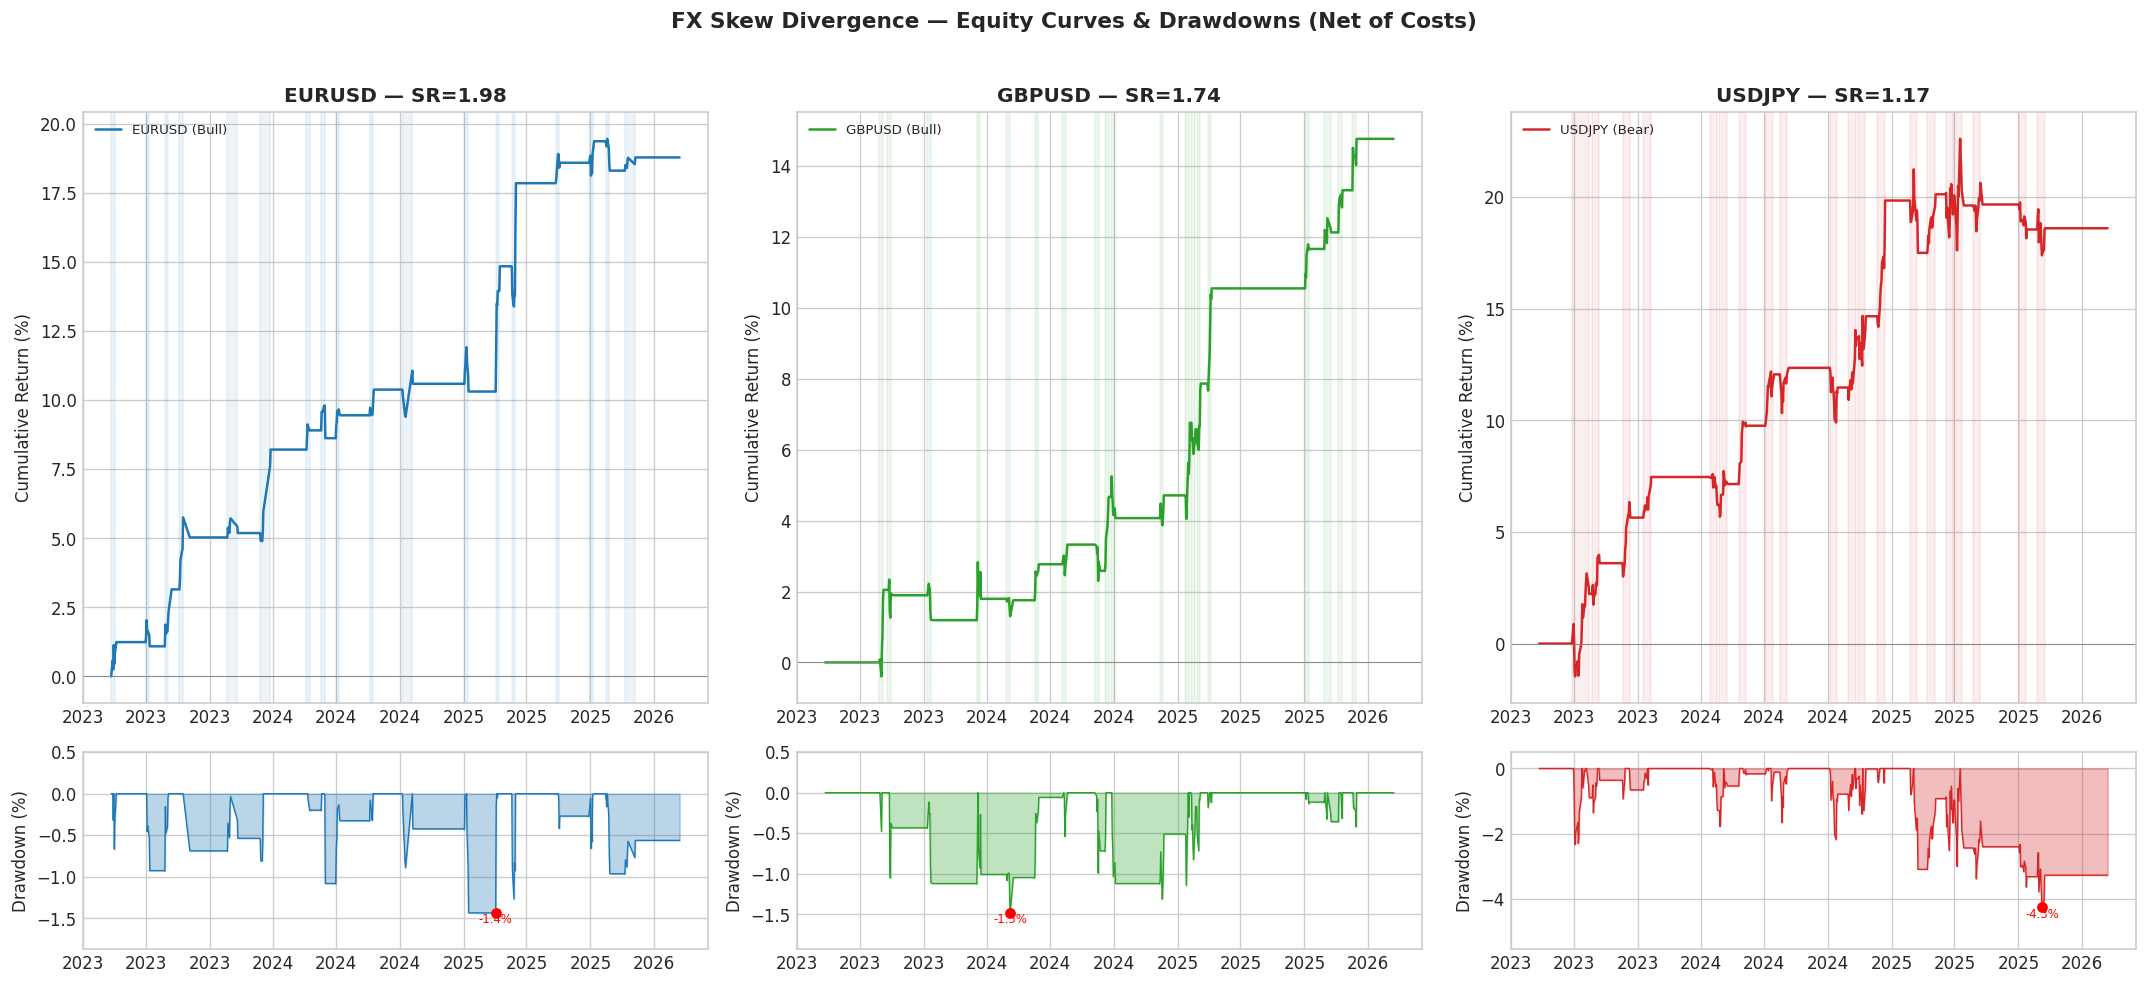

In [3]:
# Cell 2: Equity Curves & Drawdown Charts
# =========================================

fig, axes = plt.subplots(2, 3, figsize=(18, 8),
                         gridspec_kw={'height_ratios': [3, 1]})

colours = {'EUR': '#1f77b4', 'GBP': '#2ca02c', 'JPY': '#d62728'}

for i, ccy in enumerate(CURRENCIES):
    bt = backtests[ccy]['bt'].copy()
    pair = PAIR_MAP[ccy]
    config = pair_data[ccy]['config']
    colour = colours[ccy]

    # --- Top: equity curve ---
    ax = axes[0, i]
    ax.plot(bt['date'], (bt['cum_net'] - 1) * 100, color=colour, lw=1.5,
            label=f"{pair} ({config['trade_direction'].title()})")

    # Shade active periods
    active = bt['position'] != 0
    for start, end in zip(
        bt.loc[active & ~active.shift(1, fill_value=False), 'date'],
        bt.loc[active & ~active.shift(-1, fill_value=False), 'date'],
    ):
        ax.axvspan(start, end, alpha=0.08, color=colour)

    ax.set_title(f"{pair} — SR={backtests[ccy]['sharpe_net']:.2f}", fontweight='bold')
    ax.set_ylabel('Cumulative Return (%)')
    ax.axhline(0, color='grey', lw=0.5)
    ax.legend(loc='upper left', fontsize=8)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # --- Bottom: drawdown ---
    ax2 = axes[1, i]
    dd = (bt['cum_net'] / bt['cum_net'].cummax() - 1) * 100
    ax2.fill_between(bt['date'], dd, 0, color=colour, alpha=0.3)
    ax2.plot(bt['date'], dd, color=colour, lw=0.8)

    # Mark max drawdown
    max_dd_idx = dd.idxmin()
    ax2.scatter(bt.loc[max_dd_idx, 'date'], dd.iloc[max_dd_idx],
               color='red', zorder=5, s=30)
    ax2.annotate(f"{dd.iloc[max_dd_idx]:.1f}%",
                xy=(bt.loc[max_dd_idx, 'date'], dd.iloc[max_dd_idx]),
                fontsize=7, color='red', ha='center', va='top')

    ax2.set_ylabel('Drawdown (%)')
    ax2.set_ylim(dd.min() * 1.3, 0.5)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.suptitle('FX Skew Divergence — Equity Curves & Drawdowns (Net of Costs)',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

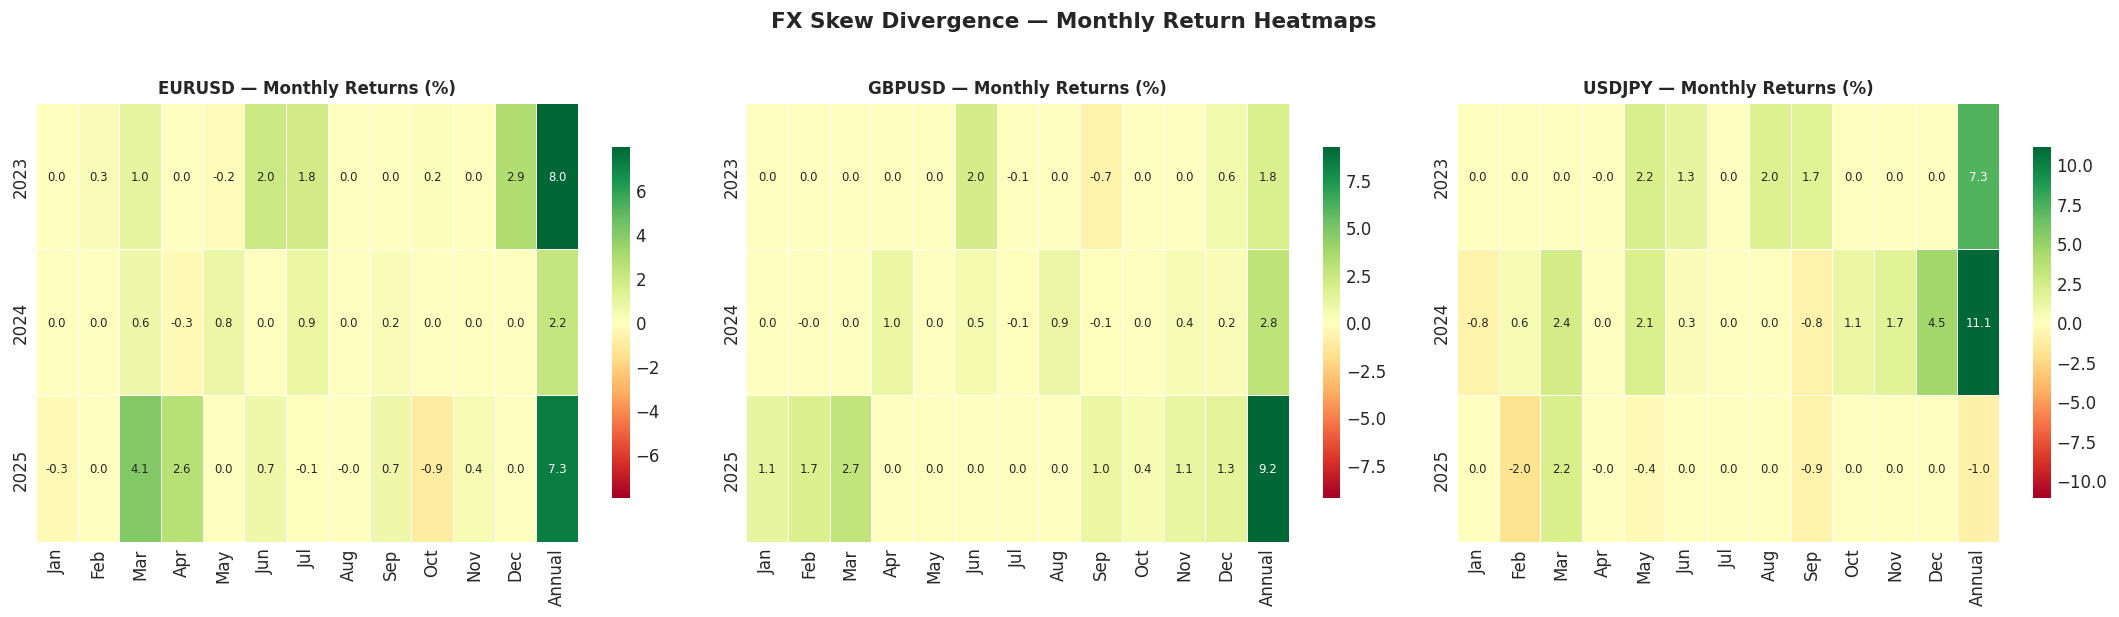

In [4]:
# Cell 3: Monthly Returns Heatmap
# =================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

month_names = ['Jan','Feb','Mar','Apr','May','Jun',
               'Jul','Aug','Sep','Oct','Nov','Dec']

for i, ccy in enumerate(CURRENCIES):
    bt = backtests[ccy]['bt'].copy()
    pair = PAIR_MAP[ccy]

    bt_idx = bt.set_index('date')
    monthly = bt_idx['net_ret'].fillna(0).resample('ME').apply(
        lambda x: (1 + x).prod() - 1
    ) * 100

    monthly_df = pd.DataFrame({
        'Year': monthly.index.year,
        'Month': monthly.index.month,
        'Return': monthly.values
    })

    # Pivot to year x month
    pivot = monthly_df.pivot_table(index='Year', columns='Month',
                                   values='Return', aggfunc='sum')

    # Rename month columns
    pivot.columns = [month_names[m - 1] for m in pivot.columns]

    # Drop incomplete final year if mostly empty
    if pivot.iloc[-1].isna().sum() > 6:
        pivot = pivot.iloc[:-1]

    # Add annual total
    pivot['Annual'] = pivot.sum(axis=1)

    # Fill NaN with 0 for display (no trades = 0 return)
    pivot = pivot.fillna(0)

    ax = axes[i]
    vmax = max(abs(pivot.values.min()), abs(pivot.values.max()), 1)
    sns.heatmap(pivot, ax=ax, cmap='RdYlGn', center=0, vmin=-vmax, vmax=vmax,
                annot=True, fmt='.1f', linewidths=0.5, cbar_kws={'shrink': 0.8},
                annot_kws={'size': 7})
    ax.set_title(f"{pair} — Monthly Returns (%)", fontweight='bold', fontsize=10)
    ax.set_ylabel('')
    ax.set_xlabel('')

fig.suptitle('FX Skew Divergence — Monthly Return Heatmaps',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

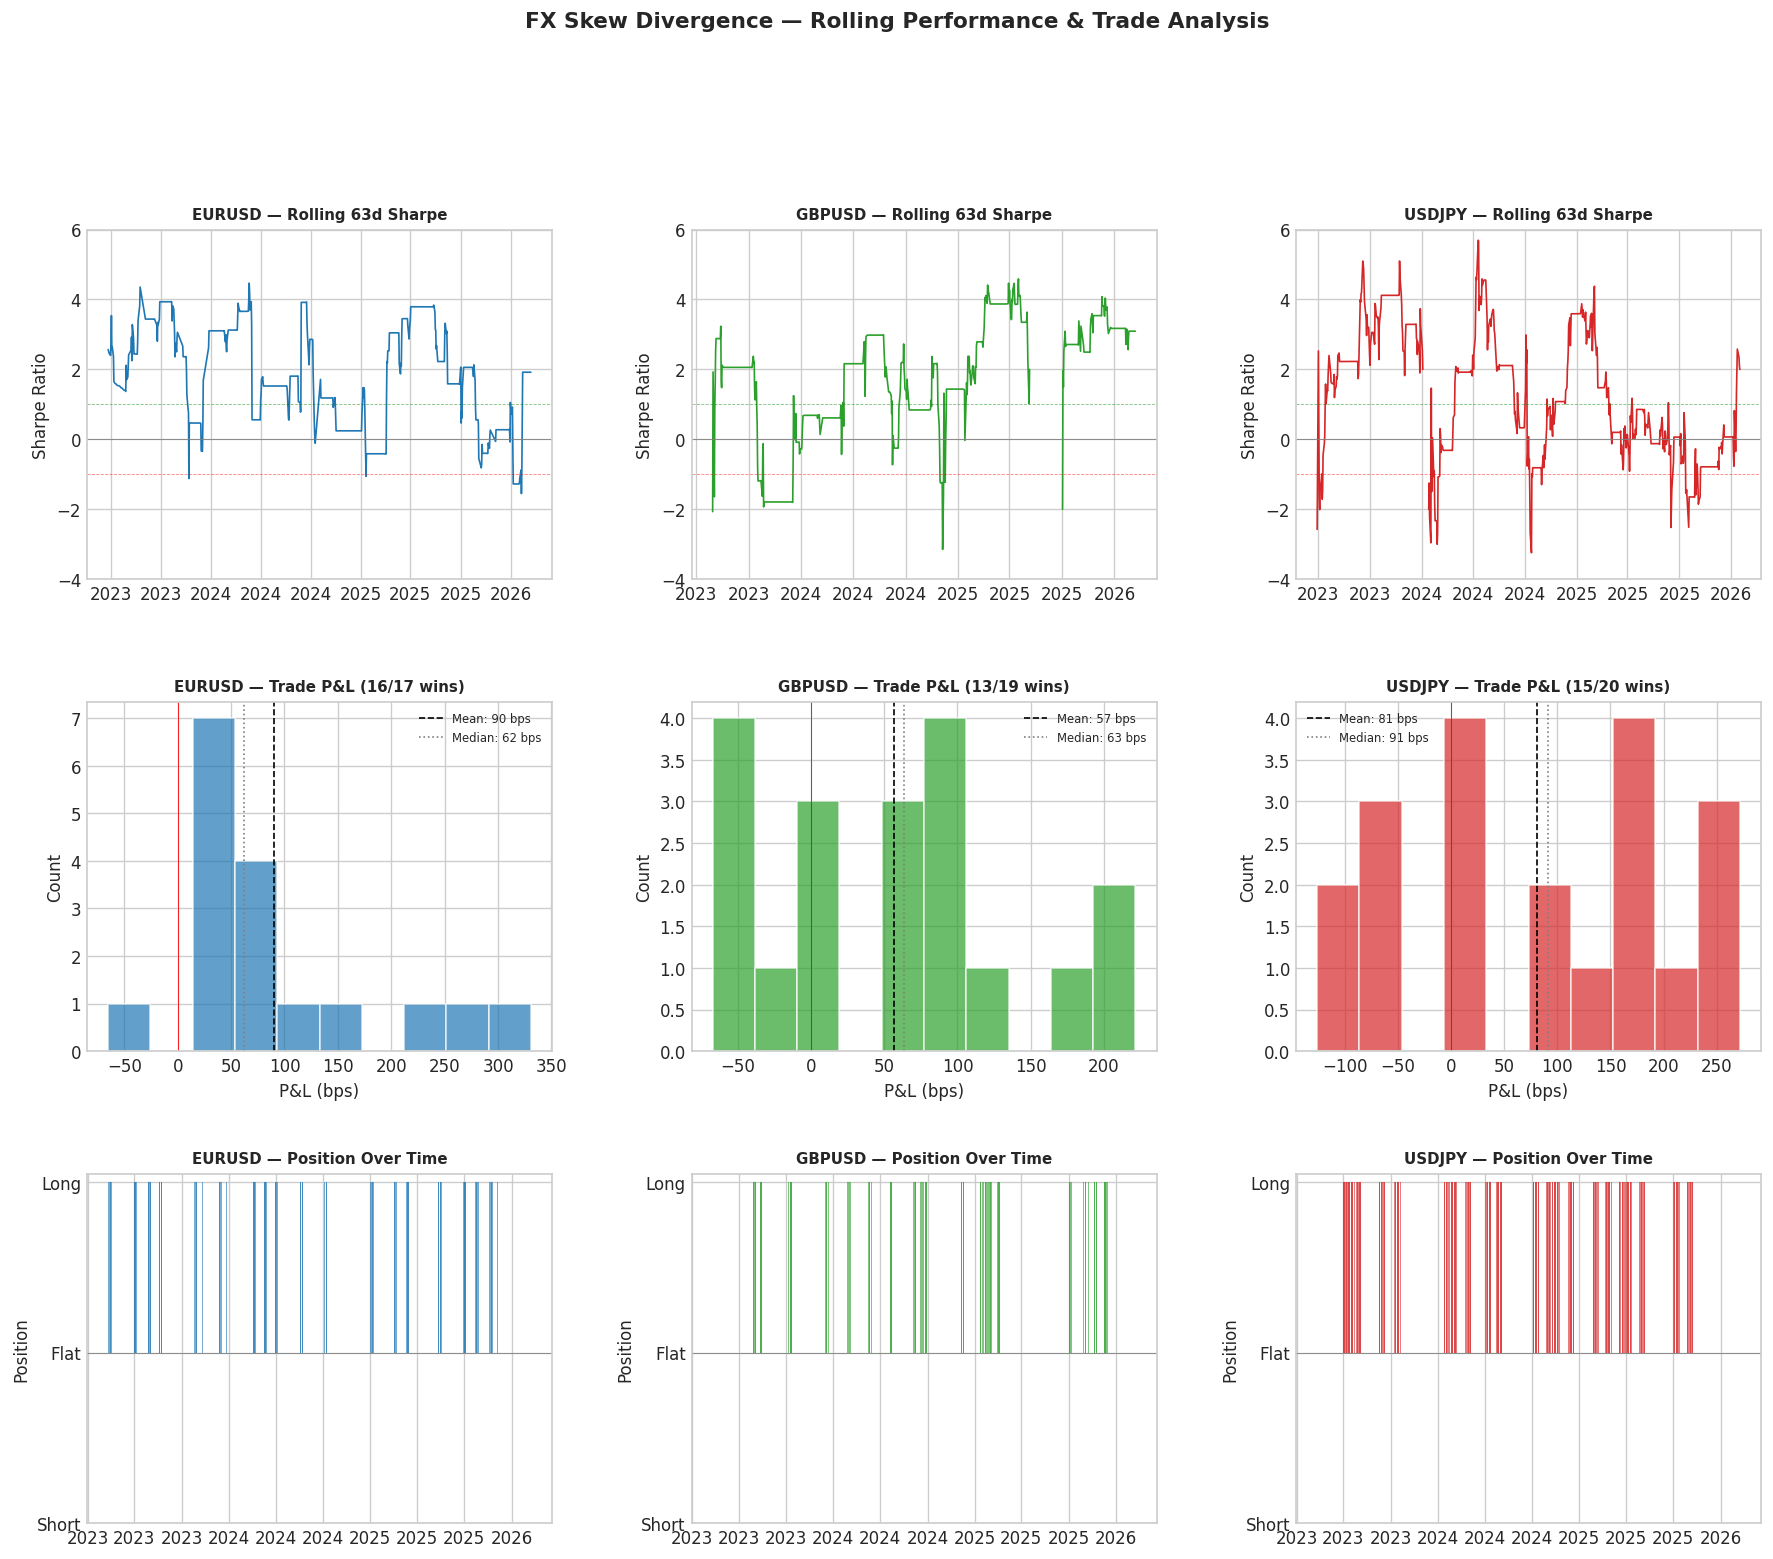

In [5]:
# Cell 4: Rolling Sharpe, Trade P&L Distribution, Position Timeline
# ===================================================================

fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

colours = {'EUR': '#1f77b4', 'GBP': '#2ca02c', 'JPY': '#d62728'}

for i, ccy in enumerate(CURRENCIES):
    bt = backtests[ccy]['bt'].copy()
    pair = PAIR_MAP[ccy]
    colour = colours[ccy]

    # --- Row 0: Rolling 63-day Sharpe ---
    ax0 = fig.add_subplot(gs[0, i])
    roll_mean = bt['net_ret'].rolling(63, min_periods=30).mean()
    roll_std = bt['net_ret'].rolling(63, min_periods=30).std()
    rolling_sr = (roll_mean / roll_std * np.sqrt(252)).replace([np.inf, -np.inf], np.nan)

    ax0.plot(bt['date'], rolling_sr, color=colour, lw=1)
    ax0.axhline(0, color='grey', lw=0.5)
    ax0.axhline(1, color='green', lw=0.5, ls='--', alpha=0.5)
    ax0.axhline(-1, color='red', lw=0.5, ls='--', alpha=0.5)
    ax0.set_title(f"{pair} — Rolling 63d Sharpe", fontweight='bold', fontsize=9)
    ax0.set_ylabel('Sharpe Ratio')
    ax0.set_ylim(-4, 6)
    ax0.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # --- Row 1: Trade-level P&L ---
    ax1 = fig.add_subplot(gs[1, i])

    # Identify individual trades by position changes
    bt['trade_id'] = (bt['pos_change'] > 0).cumsum()
    bt.loc[bt['position'] == 0, 'trade_id'] = 0

    trade_pnls = []
    for tid in bt['trade_id'].unique():
        if tid == 0:
            continue
        trade_rets = bt.loc[bt['trade_id'] == tid, 'signal_ret'].dropna()
        if len(trade_rets) > 0:
            trade_pnl = ((1 + trade_rets).prod() - 1) * 10000  # bps
            trade_pnls.append(trade_pnl)

    if trade_pnls:
        trade_pnls = np.array(trade_pnls)
        bins = max(10, len(trade_pnls) // 3)
        ax1.hist(trade_pnls, bins=bins, color=colour, alpha=0.7, edgecolor='white')
        ax1.axvline(np.mean(trade_pnls), color='black', ls='--', lw=1,
                    label=f'Mean: {np.mean(trade_pnls):.0f} bps')
        ax1.axvline(np.median(trade_pnls), color='grey', ls=':', lw=1,
                    label=f'Median: {np.median(trade_pnls):.0f} bps')
        ax1.axvline(0, color='red', lw=0.5)
        n_win = (trade_pnls > 0).sum()
        ax1.set_title(f"{pair} — Trade P&L ({n_win}/{len(trade_pnls)} wins)",
                      fontweight='bold', fontsize=9)
        ax1.legend(fontsize=7)
    ax1.set_xlabel('P&L (bps)')
    ax1.set_ylabel('Count')

    # --- Row 2: Position timeline ---
    ax2 = fig.add_subplot(gs[2, i])
    ax2.bar(bt['date'], bt['position'], width=2, color=colour, alpha=0.6)
    ax2.axhline(0, color='grey', lw=0.5)
    ax2.set_title(f"{pair} — Position Over Time", fontweight='bold', fontsize=9)
    ax2.set_ylabel('Position')
    ax2.set_yticks([-1, 0, 1])
    ax2.set_yticklabels(['Short', 'Flat', 'Long'])
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.suptitle('FX Skew Divergence — Rolling Performance & Trade Analysis',
             fontsize=13, fontweight='bold', y=1.01)
plt.show()

Combined Portfolio (Equal-Weight) KPIs
  Total Return:    14.3%
  CAGR:            4.6%
  Volatility:      2.2%
  Sharpe:          1.74
  Sortino:         2.42
  Calmar:          4.64
  Max Drawdown:    -1.0%
  Max DD Duration: 100 days
  Win Rate:        30.8%

  Avg Individual SR: 1.63
  Combined SR:       1.74
  Diversification:   +0.11


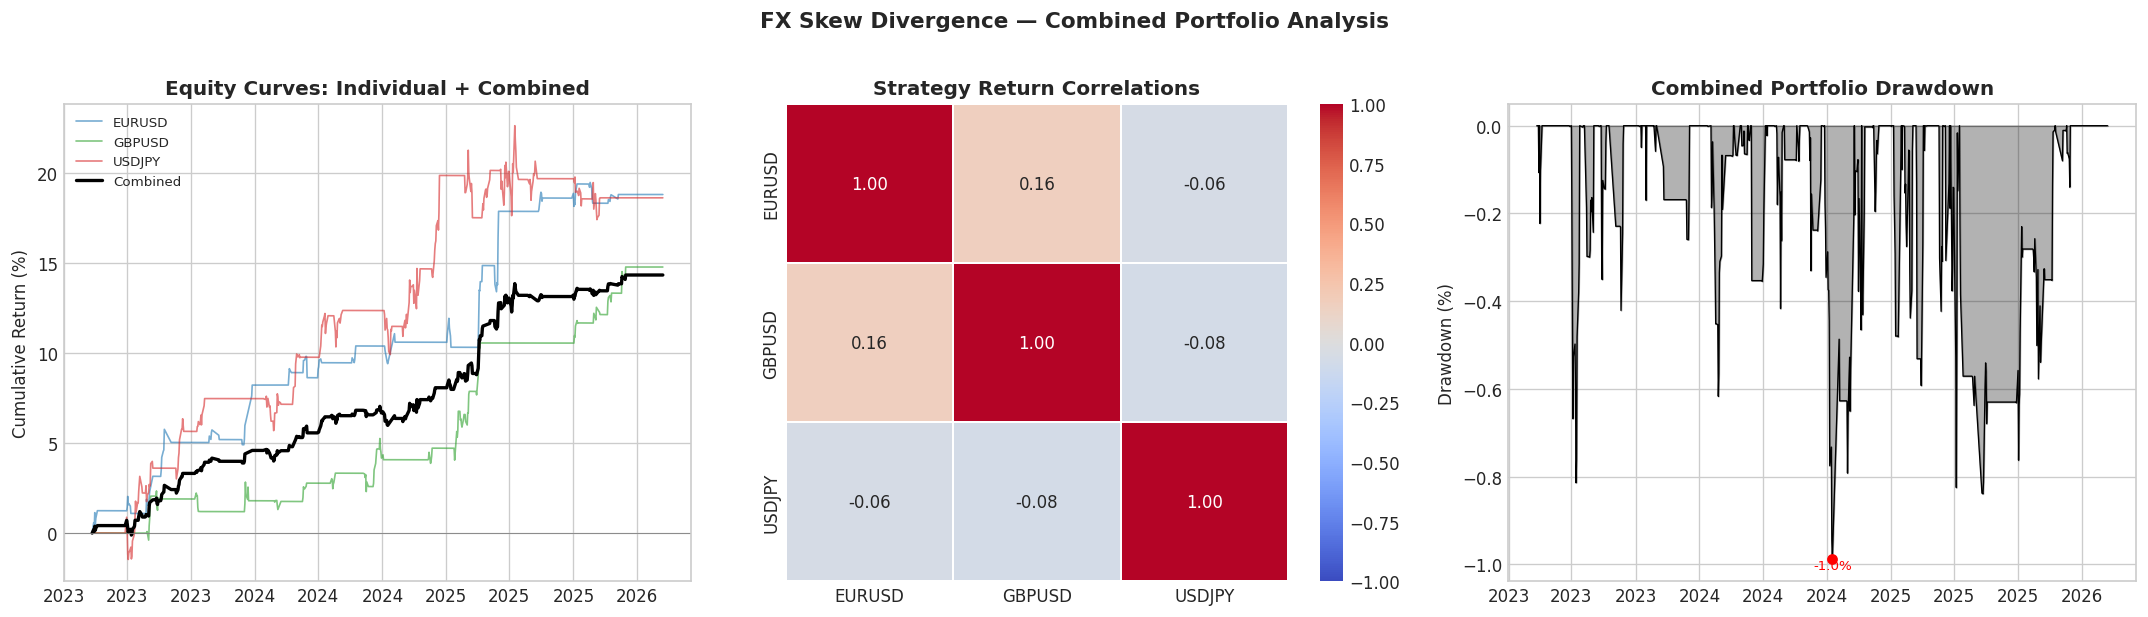

In [6]:
# Cell 5: Combined Portfolio Analysis
# =====================================

# Align all strategy returns on common dates
all_rets = {}
for ccy in CURRENCIES:
    bt = backtests[ccy]['bt'].copy()
    s = bt.set_index('date')['net_ret'].fillna(0)
    all_rets[PAIR_MAP[ccy]] = s

rets_df = pd.DataFrame(all_rets)
rets_df = rets_df.dropna()

# Equal-weight combined
rets_df['Combined'] = rets_df[list(all_rets.keys())].mean(axis=1)
rets_df['cum_combined'] = (1 + rets_df['Combined']).cumprod()

# --- KPIs for combined ---
pm = PerformanceMetrics(risk_free_rate=0.02)
combined_metrics = pm.calculate_all_metrics(
    rets_df['cum_combined'], rets_df['Combined']
)

print('Combined Portfolio (Equal-Weight) KPIs')
print('=' * 50)
print(f"  Total Return:    {combined_metrics['total_return']*100:.1f}%")
print(f"  CAGR:            {combined_metrics['cagr']*100:.1f}%")
print(f"  Volatility:      {combined_metrics['volatility']*100:.1f}%")
print(f"  Sharpe:          {combined_metrics['sharpe_ratio']:.2f}")
print(f"  Sortino:         {combined_metrics['sortino_ratio']:.2f}")
print(f"  Calmar:          {combined_metrics['calmar_ratio']:.2f}")
print(f"  Max Drawdown:    {combined_metrics['max_drawdown']*100:.1f}%")
print(f"  Max DD Duration: {combined_metrics['max_drawdown_duration']:.0f} days")
print(f"  Win Rate:        {combined_metrics['win_rate']*100:.1f}%")

# Diversification benefit
individual_srs = [backtests[c]['sharpe_net'] for c in CURRENCIES]
avg_sr = np.mean(individual_srs)
print(f"\n  Avg Individual SR: {avg_sr:.2f}")
print(f"  Combined SR:       {combined_metrics['sharpe_ratio']:.2f}")
print(f"  Diversification:   {combined_metrics['sharpe_ratio'] - avg_sr:+.2f}")

# --- Plots ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (a) Equity curves: individual + combined
ax = axes[0]
colours_list = ['#1f77b4', '#2ca02c', '#d62728']
for j, ccy in enumerate(CURRENCIES):
    bt = backtests[ccy]['bt'].copy()
    ax.plot(bt['date'], (bt['cum_net'] - 1) * 100, color=colours_list[j],
            lw=1, alpha=0.6, label=PAIR_MAP[ccy])

ax.plot(rets_df.index, (rets_df['cum_combined'] - 1) * 100,
        color='black', lw=2, label='Combined')
ax.set_title('Equity Curves: Individual + Combined', fontweight='bold')
ax.set_ylabel('Cumulative Return (%)')
ax.legend(fontsize=8)
ax.axhline(0, color='grey', lw=0.5)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# (b) Correlation matrix
ax = axes[1]
corr = rets_df[list(all_rets.keys())].corr()
sns.heatmap(corr, ax=ax, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1, linewidths=1)
ax.set_title('Strategy Return Correlations', fontweight='bold')

# (c) Combined drawdown
ax = axes[2]
dd = (rets_df['cum_combined'] / rets_df['cum_combined'].cummax() - 1) * 100
ax.fill_between(dd.index, dd, 0, color='black', alpha=0.3)
ax.plot(dd.index, dd, color='black', lw=0.8)
max_dd_idx = dd.idxmin()
ax.scatter(max_dd_idx, dd.loc[max_dd_idx], color='red', zorder=5, s=30)
ax.annotate(f"{dd.loc[max_dd_idx]:.1f}%", xy=(max_dd_idx, dd.loc[max_dd_idx]),
            fontsize=8, color='red', ha='center', va='top')
ax.set_title('Combined Portfolio Drawdown', fontweight='bold')
ax.set_ylabel('Drawdown (%)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.suptitle('FX Skew Divergence — Combined Portfolio Analysis',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()